---
# 1. 라이브러리 불러오기
----

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import librosa # 음원 데이터 분석 라이브러리 
import librosa.display as dsp
from IPython.display import Audio # 음원을 파이썬 작업환경에서 띄우는 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from tqdm.notebook import tqdm

##############################################################################
import torchvision.datasets as datasets # 데이터셋 집합체
import torchvision.transforms as transforms # 변환 툴
from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn 
##############################################################################

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # GPU 할당


---
# 2. 데이터 불러오기
----

In [3]:
path = '/content/drive/MyDrive/Audio_Study/train/01/'
sample = os.listdir(path)

# 데이터 프레임 생성
train = pd.DataFrame(sample, columns = ['file_name'])
# label 생성
train['label'] = None
for i in range(len(train)):
  train['label'][i] = train['file_name'][i][0]  

train['label'] = train['label'].astype(int)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  500 non-null    object
 1   label      500 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.9+ KB


---
# 3. 데이터 전처리
----

- sampling rate의 의미는 초당 16000개(16000Hz 주파수)의 샘플을 가지고 있는 데이터라는 의미  
(1초에 음성 신호를 16000번 sampling)

- sampling rate의 defult값은 22050Hz인데
16000Hz으로 설정한 이유는 사람의 목소리는 대부분 16000Hz 안에 포함되기 때문

- 또한 audio shape와 sampling rate를 이용해서 오디오 길이 계산 가능

In [4]:
root = path + train.file_name[0]

data, sample_rate = librosa.load(root, sr = 16000)
print('sample_rate:', sample_rate, ', audio shape:', data.shape)
print('length:', data.shape[0]/float(sample_rate), 'secs')

sample_rate: 16000 , audio shape: (9484,)
length: 0.59275 secs


---
### 3-1. 데이터셋 생성
---

In [5]:
def make_dataset(path):
  sample = os.listdir(path)
  dataset = []
  for i in tqdm(sample):
    root = path + i
    data, sample_rate = librosa.load(root, sr = 16000)
    dataset.append([data,i[0]])
  return pd.DataFrame(dataset, columns = ['data','label'])

In [6]:
# train dataset 
train = make_dataset('/content/drive/MyDrive/Audio_Study/train/01/')
# Shuffle 효과
train = train.sample(frac = 1).reset_index(drop = True)
train['label'] = train['label'].astype(int)
train

  0%|          | 0/500 [00:00<?, ?it/s]

,data,label
0,"[0.00020654655, 0.0003453609, 0.00032338014, 0...",2
1,"[-4.347965e-05, -8.101715e-05, -6.58227e-05, -...",2
2,"[0.00015933723, 0.00025396378, 0.00021941254, ...",4
3,"[6.0502196e-05, 7.623181e-05, 6.388349e-05, 0....",4
4,"[-9.361771e-05, -0.00014588157, -0.00012143476...",5
...,...,...
495,"[-4.0658513e-05, -4.3103588e-05, -5.3443004e-0...",6
496,"[2.7795135e-05, 6.066372e-05, 6.7699955e-05, 7...",6
497,"[-3.2811862e-05, -4.4503216e-05, -5.4655076e-0...",0
498,"[-5.6615925e-05, -0.000121991776, -0.000125019...",8


In [7]:
# test dataset 
test = make_dataset('/content/drive/MyDrive/Audio_Study/train/02/')
# Shuffle 효과
test = test.sample(frac = 1).reset_index(drop = True)
test = test[:200]
test['label'] = test['label'].astype(int)

  0%|          | 0/500 [00:00<?, ?it/s]

---
### 3-2. 음성 중 가장 길이가 작은 데이터를 기준으로 자르기
---

In [8]:
def get_min(data):
  min = 9999999
  for i in data['data']:
    if len(i) < min:
      min = len(i)
  return min

def get_max(data):
  max = 0
  for i in data['data']:
    if len(i) > max:
      max = len(i)
  return max  

In [9]:
print('Train 데이터 중 가장 작은 길이:', get_min(train))
print('Train 데이터 중 가장 긴 길이:',get_max(train))
print()
print('Test 데이터 중 가장 작은 길이:',get_min(test))
print('Test 데이터 중 가장 긴 길이:',get_max(test))
print()
mini = np.min([get_min(train), get_min(test)])
print('가장 작은 길이 :', mini)

Train 데이터 중 가장 작은 길이: 6136
Train 데이터 중 가장 긴 길이: 14651

Test 데이터 중 가장 작은 길이: 7652
Test 데이터 중 가장 긴 길이: 15069

가장 작은 길이 : 6136


In [10]:
def cut_length(data, cut):
  result = []
  for i in data['data']:
    result.append(i[ : cut ])
  return np.array(result)

In [11]:
train_x = cut_length(train,mini)
test_x = cut_length(test,mini)

In [12]:
print('train :', train_x.shape)
print('test :', test_x.shape)

train : (500, 6136)
test : (200, 6136)


---
### 3-3. MFCC (Mel-frequency cepstral coefficients)
----

- 음성데이터 전체를 퓨리에 변환을 할경우  예를들어 "안녕하세요"라고 하더라도, 어떤 사람은 1초, 어떤 사람은 3초가 걸릴 수도 있다

- 따라서 이 천차만별인 길이에 대하여 같은 "안녕하세요"라는 음성이라고 학습시키기는 어려울 것

- 위와 같은 문제를 해결하기 위하여 MFCC (Mel-frequency cepstral coefficients) 알고리즘을 이용

- MFCC는 **음성데이터를 특징벡터화 해주는 알고리즘**입니다.

- 입력된 소리 전체를 대상으로 하는 것이 아니라, 사람이 인지하기 좋은 Mel-scale로 음성데이터를 모두 20~40ms로 나누어 이 구간에 대한 스펙트럼을 분석하여 퓨리에 변환을 한 특징 추출 방법

- 사람의 음성은 20~40ms 사이에서는 음소(현재 내고 있는 발음)가 바뀔 수 없다는 연구결과들을 기반으로 음소는 해당 시간내에 바뀔 수 없다고 가정

- 따라서 MFCC에서는 음성데이터를 모두 20~40ms 단위로 쪼개고, 쪼갠 단위에 대해서 Mel 값을 뽑아서 Feature로 사용

- y : audio data

- sr : sampling rate

- n_mfcc : return 될 mfcc의 개수를 정해주는 파라미터. 더 다양한 데이터 특징을 추출하기 위해서 증가 

- n_fft : frame의 length를 결정하는 파라미터. n_fft를 설정하면 디폴트 값으로 window size가 = _fft

- hop_length : 윈도우 길이 / 길이만큼 옆으로 가면서 데이터를 읽음  
  window 간의 거리이므로 sampling rate * frame_stride 가 됩니다.

In [13]:
def preprocess_dataset(data):
    mfccs = []
    for i in data:
                                                                 # 반환할 MFCC의 수 
        extracted_features = librosa.feature.mfcc(y=i, sr=16000, n_mfcc=40) 
                                                       # sample_rate
        mfccs.append(extracted_features)
            
    return mfccs

In [14]:
train_mfccs = preprocess_dataset(train_x)
train_mfccs = np.array(train_mfccs)
train_mfccs = train_mfccs.reshape(-1, train_mfccs.shape[1], train_mfccs.shape[2], 1)

In [15]:
test_mfccs = preprocess_dataset(test_x)
test_mfccs = np.array(test_mfccs)
test_mfccs = test_mfccs.reshape(-1, test_mfccs.shape[1], test_mfccs.shape[2], 1)

In [16]:
print(train_mfccs.shape)
print(test_mfccs.shape)

(500, 40, 12, 1)
(200, 40, 12, 1)


---
### 3-4. 데이터셋 분리
---

In [17]:
train_X = train_mfccs[ : 300]
val_X = train_mfccs[300 : ]
train_y = train.label[ : 300]
val_y = train.label[300 : ]
val_y = val_y.reset_index(drop=True)
test_X = test_mfccs
test_y = test.label

In [18]:
print(train_X.shape)
print(train_y.shape)
print(val_X.shape)
print(val_y.shape)
print(test_X.shape)
print(test_y.shape)

(300, 40, 12, 1)
(300,)
(200, 40, 12, 1)
(200,)
(200, 40, 12, 1)
(200,)


---
# 4. Custom Dataset
----

In [19]:
class CustomDataset(Dataset):
  def __init__(self, x, y, train_mode = True, transforms = None):
    self.x = x
    self.y = y
    self.train_mode = train_mode
    self.transforms = transforms

  def __getitem__(self, index): #index번째 data를 return
    x = self.x[index]
    
    if self.transforms is not None:
        x = self.transforms(x)

    if self.train_mode:
        y = self.y[index]
        return x, y
    else:
        return x

  def __len__(self):   
      return len(self.x)

    

In [20]:
# 배치 사이즈 설정
batch_size = 10

#만든 train dataset를 DataLoader에 넣어 batch 만들기
train_dataset = CustomDataset(x=train_X, y=train_y)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

val_dataset = CustomDataset(x=val_X, y=val_y)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)

test_dataset = CustomDataset(x=test_X, y=test_y)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [21]:
train_batches = len(train_loader)
val_batches = len(val_loader)

print('/ total train batches :', train_batches)
print('/ total valid batches :', val_batches)

/ total train batches : 30
/ total valid batches : 20


---
# 5. Model
---

In [22]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()

    self.layer1 = nn.Sequential(
                        nn.Conv2d(40,10, kernel_size = 2, stride = 1, padding = 1), # cnn
                        nn.ReLU(), # active function
                        nn.MaxPool2d(kernel_size = 2, stride = 2) # pooling
                        )

    self.layer2 = nn.Sequential(
                        nn.Conv2d(10,50, kernel_size = 2, stride = 1, padding = 1), # cnn
                        nn.ReLU(), # active function
                        nn.MaxPool2d(kernel_size = 2, stride = 2) # pooling
                        )

    self.layer3 = nn.Sequential(
                        nn.Conv2d(50,100, kernel_size = 2, stride = 1, padding = 1), # cnn
                        nn.ReLU(), # active function
                        nn.MaxPool2d(kernel_size = 2, stride = 2) # pooling
                        )

    self.layer4 = nn.Sequential(
                        nn.Conv2d(100,200, kernel_size = 2, stride = 1, padding = 1), # cnn
                        nn.ReLU(), # active function
                        nn.MaxPool2d(kernel_size = 2, stride = 2) # pooling
                        )
    self.fc_layer = nn.Sequential(
                        nn.Linear(200,10)
                        )
    
  def forward(self,x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = torch.flatten(x, start_dim = 1) # N차원 배열에서 1차원 배열로 변환
    out = self.fc_layer(x)
    return out

In [23]:
import torch.optim as optim # 최적화 알고리즘들이 포함힘

# 에포크 설정
num_epochs = 50

model = CNN().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-4 )

print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(40, 10, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 50, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(50, 100, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(100, 200, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=200, out_features=10, bias=True)
  )
)


---
# 6. Train
---

In [24]:
train_graph_loss = []
val_graph_loss = []
val_graph_acc = []

for epoch in range(num_epochs):
  model.train() # 모델 학습
  total_loss = 0.0

  for data, label in tqdm(train_loader):
    data = data.to(device)
    label = label.to(device)

    # predict
    logits = model(data)

    # loss
    loss = criterion(logits, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  train_graph_loss.append(total_loss / len(train_loader))
  print(f'epcoh : {epoch + 1} loss: {round(total_loss / len(train_loader),5)}')

#################################### validation ################################################

  model.eval()
  total_val_loss = 0.0
  Accuracy = 0.0
  with torch.no_grad():
    for data, label in tqdm(val_loader):
      data = data.to(device)
      label = label.to(device)

      logits = model(data)
      total_val_loss += criterion(logits, label).item()

      pred = logits.argmax(1, keepdim = True)
      
      # view_as() 함수는 target 텐서를 view_as() 함수 안에 들어가는 인수(pred)의 모양대로 다시 정렬
      # eq를 통해 pred과 shape이 변형된 label값을 비교해서 같으면 1 아니면 0으로 산출 
      # 해당 값을 모두 더하면 맞은 개수가 나옴
      Accuracy += pred.eq(label.view_as(pred)).sum().item() 
  val_graph_loss.append(total_val_loss / len(val_loader))
  val_graph_acc.append(Accuracy / len(val_loader.dataset))

  print(f'val_epcoh : {epoch + 1} val_loss: {round(total_val_loss / len(val_loader),5)} val_Accuracy: {(Accuracy / len(val_loader.dataset))}')    
    

  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 1 loss: 2.72497


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 1 val_loss: 2.24945 val_Accuracy: 0.19


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 2 loss: 2.14673


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 2 val_loss: 2.07057 val_Accuracy: 0.315


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 3 loss: 2.00939


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 3 val_loss: 1.93392 val_Accuracy: 0.32


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 4 loss: 1.86239


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 4 val_loss: 1.76216 val_Accuracy: 0.625


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 5 loss: 1.68561


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 5 val_loss: 1.61065 val_Accuracy: 0.5


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 6 loss: 1.53684


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 6 val_loss: 1.47124 val_Accuracy: 0.56


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 7 loss: 1.40387


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 7 val_loss: 1.28983 val_Accuracy: 0.745


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 8 loss: 1.23053


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 8 val_loss: 1.15266 val_Accuracy: 0.76


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 9 loss: 1.08242


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 9 val_loss: 1.02809 val_Accuracy: 0.73


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 10 loss: 1.00198


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 10 val_loss: 0.91962 val_Accuracy: 0.72


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 11 loss: 0.86498


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 11 val_loss: 0.86734 val_Accuracy: 0.74


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 12 loss: 0.77696


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 12 val_loss: 0.77476 val_Accuracy: 0.815


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 13 loss: 0.7122


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 13 val_loss: 0.70475 val_Accuracy: 0.82


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 14 loss: 0.61567


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 14 val_loss: 0.62658 val_Accuracy: 0.85


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 15 loss: 0.55885


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 15 val_loss: 0.57927 val_Accuracy: 0.86


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 16 loss: 0.50733


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 16 val_loss: 0.57708 val_Accuracy: 0.86


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 17 loss: 0.47076


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 17 val_loss: 0.48652 val_Accuracy: 0.85


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 18 loss: 0.43023


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 18 val_loss: 0.43308 val_Accuracy: 0.95


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 19 loss: 0.37433


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 19 val_loss: 0.38394 val_Accuracy: 0.965


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 20 loss: 0.32943


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 20 val_loss: 0.36564 val_Accuracy: 0.945


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 21 loss: 0.30438


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 21 val_loss: 0.34907 val_Accuracy: 0.94


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 22 loss: 0.29105


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 22 val_loss: 0.30811 val_Accuracy: 0.96


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 23 loss: 0.24677


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 23 val_loss: 0.27932 val_Accuracy: 0.955


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 24 loss: 0.23071


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 24 val_loss: 0.27391 val_Accuracy: 0.95


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 25 loss: 0.22387


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 25 val_loss: 0.22511 val_Accuracy: 0.975


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 26 loss: 0.16974


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 26 val_loss: 0.21697 val_Accuracy: 0.965


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 27 loss: 0.15821


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 27 val_loss: 0.19476 val_Accuracy: 0.97


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 28 loss: 0.14969


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 28 val_loss: 0.18589 val_Accuracy: 0.975


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 29 loss: 0.13684


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 29 val_loss: 0.15931 val_Accuracy: 0.985


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 30 loss: 0.12858


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 30 val_loss: 0.16576 val_Accuracy: 0.98


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 31 loss: 0.11756


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 31 val_loss: 0.14937 val_Accuracy: 0.975


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 32 loss: 0.10648


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 32 val_loss: 0.13502 val_Accuracy: 0.98


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 33 loss: 0.11193


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 33 val_loss: 0.13673 val_Accuracy: 0.975


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 34 loss: 0.09403


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 34 val_loss: 0.12226 val_Accuracy: 0.985


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 35 loss: 0.08538


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 35 val_loss: 0.12925 val_Accuracy: 0.975


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 36 loss: 0.0769


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 36 val_loss: 0.11921 val_Accuracy: 0.975


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 37 loss: 0.07221


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 37 val_loss: 0.10902 val_Accuracy: 0.97


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 38 loss: 0.06775


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 38 val_loss: 0.106 val_Accuracy: 0.975


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 39 loss: 0.06485


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 39 val_loss: 0.10878 val_Accuracy: 0.975


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 40 loss: 0.05737


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 40 val_loss: 0.097 val_Accuracy: 0.985


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 41 loss: 0.05378


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 41 val_loss: 0.0951 val_Accuracy: 0.98


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 42 loss: 0.05494


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 42 val_loss: 0.08847 val_Accuracy: 0.98


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 43 loss: 0.05044


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 43 val_loss: 0.09257 val_Accuracy: 0.98


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 44 loss: 0.04436


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 44 val_loss: 0.0857 val_Accuracy: 0.98


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 45 loss: 0.04168


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 45 val_loss: 0.08668 val_Accuracy: 0.98


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 46 loss: 0.03666


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 46 val_loss: 0.08885 val_Accuracy: 0.98


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 47 loss: 0.03971


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 47 val_loss: 0.07855 val_Accuracy: 0.98


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 48 loss: 0.03286


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 48 val_loss: 0.08119 val_Accuracy: 0.975


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 49 loss: 0.03302


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 49 val_loss: 0.07581 val_Accuracy: 0.98


  0%|          | 0/30 [00:00<?, ?it/s]

epcoh : 50 loss: 0.03018


  0%|          | 0/20 [00:00<?, ?it/s]

val_epcoh : 50 val_loss: 0.07114 val_Accuracy: 0.975


---
# 7. Inference
---

In [25]:
def model_inference(model, test_loader, device):
  model.eval()
  test_acc = 0
  inference = []
  with torch.no_grad():
    for data, label in tqdm(test_loader):
      data = data.to(device)
      logits = model(data)
      pred = logits.argmax(1, keepdim = True)
      inference.extend(pred.squeeze(1).tolist()) # [괄호]를 없애고 넣기 위해 extend 사용
      test_acc += pred.eq(label.view_as(pred)).sum().item() 
    print(f'Accuracy: {(test_acc / len(test_loader.dataset))}')
  return inference

In [26]:
pred = model_inference(model, test_loader, device)

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy: 0.655


Text(0.5, 1.0, 'validation_Accuracy')

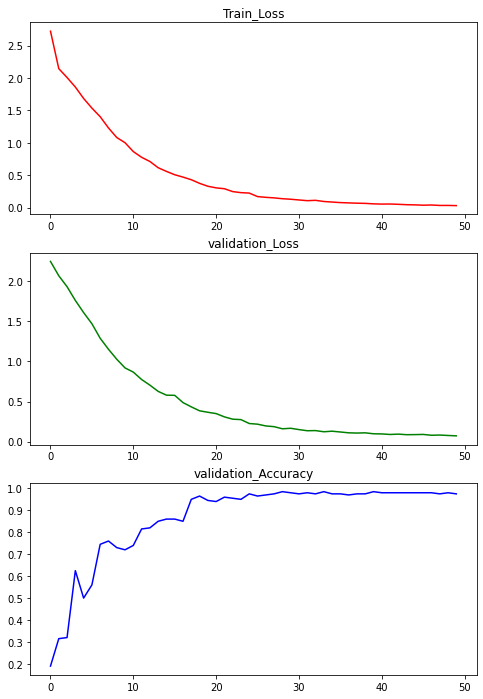

In [42]:
fig, ax = plt.subplots(3, 1, figsize = (8,12))

ax[0].plot(train_graph_loss,'r')
ax[0].set_title('Train_Loss')

ax[1].plot(val_graph_loss,'g')
ax[1].set_title('validation_Loss')

ax[2].plot(val_graph_acc,'b')
ax[2].set_title('validation_Accuracy')